# Reflected Slab - Two Group

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

import openmc

%matplotlib inline

## Multigroup Cross Sections

In [2]:
groups = openmc.mgxs.EnergyGroups(np.logspace(-5,7,3))

# Define core XS data
core_xsdata = openmc.XSdata('core', groups)
core_xsdata.order = 0

core_xsdata.set_total([0.276, 1.063], temperature=294.)
core_xsdata.set_absorption([0.012, 0.121], temperature=294.)
core_xsdata.set_fission([0.00339, 0.074], temperature=294.)
core_xsdata.set_nu_fission([2.5*0.00339, 2.5*0.074], temperature=294.)
core_xsdata.set_chi([1.0, 0.0], temperature=294.)

core_scatter = [[[0.25, 0.014],
                 [0.0, 0.942]]]
core_scatter = np.array(core_scatter)
core_scatter = np.rollaxis(core_scatter, 0, 3)
core_xsdata.set_scatter_matrix(core_scatter, temperature=294.)

# Define reflector XS data
ref_xsdata = openmc.XSdata('ref', groups)
ref_xsdata.order = 0

ref_xsdata.set_total([0.295, 2.1], temperature=294.)
ref_xsdata.set_absorption([0.0004, 0.02], temperature=294.)
ref_xsdata.set_fission([0.0, 0.0], temperature=294.)

ref_scatter = [[[0.2456, 0.049],
                [0.0, 2.08]]]
ref_scatter = np.array(ref_scatter)
ref_scatter = np.rollaxis(ref_scatter, 0, 3)
ref_xsdata.set_scatter_matrix(ref_scatter, temperature=294.)

In [3]:
mg_xs_file = openmc.MGXSLibrary(groups)
mg_xs_file.add_xsdata(core_xsdata)
mg_xs_file.add_xsdata(ref_xsdata)

mg_xs_file.export_to_hdf5('mgxs.h5')

## Materials

In [4]:
materials = {}
for xs in ['core', 'ref']:
    materials[xs] = openmc.Material(name=xs)
    materials[xs].set_density('macro', 1.0)
    materials[xs].add_macroscopic(xs)
    
materials_file = openmc.Materials(materials.values())
materials_file.cross_sections = 'mgxs.h5'
materials_file.export_to_xml()

## Geometry

In [5]:
x1 = openmc.XPlane(x0 = 0.0, boundary_type='vacuum')
x2 = openmc.XPlane(x0 = 30.0)
x3 = openmc.XPlane(x0 = 70.0)
x4 = openmc.XPlane(x0 = 100.0, boundary_type='vacuum')

LRef = openmc.Cell(fill=materials['ref'], region= +x1 & -x2)
Core = openmc.Cell(fill=materials['core'], region= +x2 & -x3)
RRef = openmc.Cell(fill=materials['ref'], region= +x3 & -x4)

universe = openmc.Universe()
universe.add_cells([LRef,Core,RRef])

geom = openmc.Geometry(universe)
geom.export_to_xml()

## Tallies

In [7]:
tallies_file = openmc.Tallies()

mesh = openmc.RegularMesh()
mesh.dimension = [200]
mesh.lower_left = [0.0]
mesh.upper_right = [100.0]
mesh_filter = openmc.MeshFilter(mesh)

energy_filter = openmc.EnergyFilter([1.e-05, 1.e+01, 1.e+07])

tally = openmc.Tally(name="flux tally")
tally.filters = [mesh_filter, energy_filter]
tally.scores = ["flux"]

tallies_file.append(tally)
tallies_file.export_to_xml()

## Settings

In [2]:
settings_file = openmc.Settings()
settings_file.batches = 105
settings_file.inactive = 5
settings_file.particles = 1000000

settings_file.energy_mode = 'multi-group'

bounds = [30.0, -4.0, -4.0, 70.0, 4.0, 4.0]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.Source(space=uniform_dist)

entropy_mesh = openmc.RegularMesh()
entropy_mesh.lower_left = (30.0, -10e6, -10e6)
entropy_mesh.upper_right = (70.0, 10e6, 10e6)
entropy_mesh.dimension = (200, 1, 1)
settings_file.entropy_mesh = entropy_mesh

settings_file.run_mode = 'eigenvalue'
settings_file.export_to_xml()

In [9]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Flux Plot

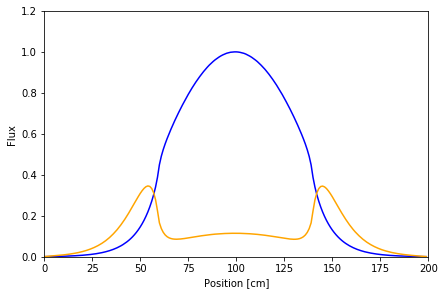

In [17]:
sp = openmc.StatePoint('statepoint.'+str(settings_file.batches)+'.h5')
flux_tally = sp.get_tally(name='flux tally')
flux = flux_tally.get_values(scores=['flux'])

Flux_Fast = []
Flux_Therm = []
for i in range(len(flux)):
    if (i%2 == 0):
        Flux_Therm.append(flux[i][0][0])
    else:
        Flux_Fast.append(flux[i][0][0])
        
# Normalize Flux
Max = 0.0
for i in range(len(Flux_Fast)):
    if(Flux_Fast[i] > Max): Max = Flux_Fast[i]
    if(Flux_Therm[i] > Max): Max = Flux_Therm[i]
    
for i in range(len(Flux_Fast)):
    Flux_Fast[i] /= Max
    Flux_Therm[i] /= Max

plt.plot(Flux_Fast, c='blue')
plt.plot(Flux_Therm, c='orange')
plt.tight_layout()
plt.xlabel('Position [cm]')
plt.ylabel('Flux')
plt.xlim([0,200])
plt.ylim([0,1.2])
plt.show()